In [ ]:
# !pip install eli5

In [1]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf
# # [런타임다시시작]

In [2]:
# df_p = pd.read_spss('/content/Koweps_p16_2021_beta1.sav')
# df_h = pd.read_spss('/content/Koweps_h16_2021_beta1.sav')
# df_hpc = pd.read_spss('/content/Koweps_hpc16_2021_beta1.sav')

In [3]:
# df_hpc.to_csv("hpc.csv", index=False)
# df_h.to_csv("h.csv", index=False)
# df_p.to_csv("p.csv", index=False)

In [4]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import RandomizedSearchCV

import eli5
from eli5.sklearn import PermutationImportance

%matplotlib inline
plt.rc('font', family='NanumBarunGothic')

In [5]:
df_p = pd.read_csv('/content/p.csv')
df_h = pd.read_csv('/content/h.csv')

In [6]:
mapping_h = pd.read_excel('/content/mapping_h.xlsx')
mapping_p = pd.read_excel('/content/mapping_p.xlsx')
mapping_neg = pd.read_excel('/content/mapping_neg.xlsx')

In [7]:
# 높을수록 부정적이라고 하기 위해 abs(x-5)를 취해준다.
df_p[mapping_neg['q'].to_list()] = df_p[mapping_neg['q'].to_list()].applymap(lambda x: abs(x-5))

In [8]:
# 컬럼명을 원래 질문으로 변환
all_h = df_h[mapping_h['q'].to_list()]
all_h.columns = mapping_h['name']

all_p = df_p[mapping_p['q'].to_list()]
all_p.columns = mapping_p['name']

# 머지 키를 기준으로 all_h와 all_p를 이너 조인 하여 all 컬럼 생성
all = pd.merge(all_h, all_p, 'inner', '머지 키')

In [9]:
# 지표들을 합쳐서 총점 84점의 부정지수를 만들고 재료 삭제
all['부정지수'] = all[all.columns[23:]].sum(axis=1)
all = all.drop(all.columns[23:-1],axis=1)

In [10]:
# 태어난 연도를 연령대로 변경
all['태어난 연도'] = all['태어난 연도'].apply(lambda x: 2021 - x)
all.rename(columns={'태어난 연도':'연령대'}, inplace=True)
all['연령대'] = all['연령대'] // 10 * 10

In [11]:
# 일부 값을 이상치로 판단하여 드랍
all = all.drop(all[all['주거면적'] > 200].index, axis=0)
all = all.drop(all[all['총생활비'] > 2000].index, axis=0)
all = all.drop(all[all['가구원수'] == 7].index, axis=0)
all = all.drop(all[all['사회적 친분관계 만족도'] == 9].index, axis=0)

In [12]:
# 특성 값 정리
# 교육수준 없음, 초등학교, 중학교, 고등학교, 대학교, 대학원으로 구분
all['교육수준'] = all['교육수준'].apply(lambda x: 1 if x <= 2 else x)
all['교육수준'] = all['교육수준'].apply(lambda x: x -1 if (x >=3) & (x <= 5) else x)
all['교육수준'] = all['교육수준'].apply(lambda x: 5 if (x == 6) | (x == 7) else x)
all['교육수준'] = all['교육수준'].apply(lambda x: 6 if (x == 8) | (x == 9) else x)
# 장애종류 1 없음. 2 있음
all['장애종류'] = all['장애종류'].apply(lambda x: 1 if x == 0 else 2)
# 건강 상태 높을수록 좋음
all['건강상태'] = all['건강상태'].apply(lambda x: abs(x-6))
# 만성질환 여부 1 없음. 2 있음
all['만성질환'] = all['만성질환'].apply(lambda x: 1 if x == 0 else 2)
# 높을수록 근로 능력이 높음
all['근로 능력 정도'] = all['근로 능력 정도'].apply(lambda x: abs(x-5))
# 주택 유형에서 세분화된 주택은 주택 하나로 합치고 아파트, 오피스텔, 원룸은 그 다음 값으로, 나머지는 기타로 처리
all['주택유형'] = all['주택유형'].apply(lambda x: 1 if x <= 4 else x)
all['주택유형'] = all['주택유형'].apply(lambda x: 2 if x == 5 else x)
all['주택유형'] = all['주택유형'].apply(lambda x: 3 if (x == 6) | (x == 13) else x)
all['주택유형'] = all['주택유형'].apply(lambda x: 4 if x == 9 else x)
all['주택유형'] = all['주택유형'].apply(lambda x: 5 if (x == 7) | (x == 8) | (x >= 10) else x)
# 1. 자가 2. 전세 3. 월세 4. 기타
all['집의 (등기상) 점유형태'] = all['집의 (등기상) 점유형태'].apply(lambda x: 3 if x == 4 else x)
all['집의 (등기상) 점유형태'] = all['집의 (등기상) 점유형태'].apply(lambda x: 4 if x >= 5 else x)
# 종교 여부 1 없음. 2 있음
all['종교'] = all['종교'].apply(lambda x: 2 if x == 1 else 1)

In [13]:
# 컬럼 순서 변경
all = all[['머지 키', '가구원수', '7개 권역별 지역구분', '성별', '연령대', '교육수준', '장애종류', '종교', '건강상태',
       '만성질환', '근로 능력 정도', '주택유형', '주거면적', '집의 (등기상) 점유형태', '총생활비', '가족의 수입 만족도',
       '주거 환경 만족도', '가족관계 만족도', '직업 만족도', '사회적 친분관계 만족도', '여가생활 만족도', '부정지수']]

In [14]:
# 결측치 처리
all = all.dropna(axis=0).reset_index(drop=True)

In [15]:
# 1인가구 데이터 프레임 생성
one = all[all['가구원수'] == 1].reset_index(drop=True)

In [16]:
# 1인가구에서 이상치로 보이는 값 삭제
one = one.drop(one[one['총생활비'] >= 1000].index, axis=0)

In [17]:
all.to_csv('all.csv',index=False)
one.to_csv('one.csv',index=False)

In [18]:
# 독립변수 종속변수 분리
features = one[one.columns[2:-1]]
target = one['부정지수']

In [19]:
# 독립변수 로그 변환
features = np.log(features+1)

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


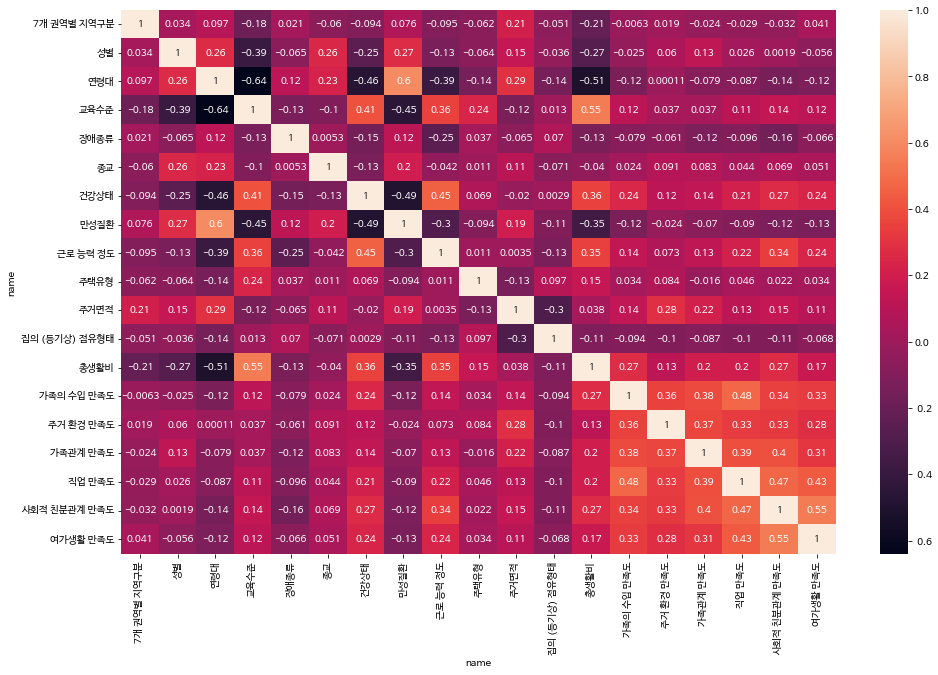

In [20]:
# 다중공선성 판단을 위해 상관계수 분석
heat = features.corr()

plt.figure(figsize=(16,10))
sns.heatmap(heat, annot=True)
plt.show()

In [ ]:
# 0.6 이상을 기준으로 잡고 교육수준과 만성질환을 드랍
features = features.drop(['교육수준','만성질환'], axis=1)

In [25]:
# 훈련 테스트 세트 분리
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [26]:
# 기준 모델
base = y_train.values.mean()
baseline = [base] * y_train.shape[0]
print('base mae', mean_absolute_error(y_train, baseline))
print('base r2 :', r2_score(y_train, baseline))

base mae 7.700534841352701
base r2 : 0.0


In [27]:
# 랜덤포레스트 기본
rfr = RandomForestRegressor(
    random_state=42
    )

rfr.fit(X_train, y_train)
train_predict = rfr.predict(X_train)
test_predict = rfr.predict(X_test)

print('RandomForest train mae :', mean_absolute_error(y_train, train_predict))
print('RandomForest train r2 :', r2_score(y_train, train_predict))
print('RandomForest test mae :', mean_absolute_error(y_test, test_predict))
print('RandomForest test r2 :', r2_score(y_test, test_predict))

RandomForest train mae : 1.9961452184179458
RandomForest train r2 : 0.9280353119155483
RandomForest test mae : 5.372783018867925
RandomForest test r2 : 0.43413257045922093


In [31]:
# 하이퍼 파라미터
n_estimators = [50,100,200,400]
max_features = ['auto','sqrt']
max_depth = [4,6,8,10,12]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [38]:
# 랜덤서치를 통한 하이퍼 파라미터 조정
rfr = RandomForestRegressor()

rfr_random = RandomizedSearchCV(estimator = rfr, param_distributions = random_grid, n_iter = 100, cv = 5, random_state=42, n_jobs = -1)

rfr_random.fit(X_train, y_train)

train_best_predict = rfr_random.predict(X_train)
test_best_predict = rfr_random.predict(X_test)

print('RandomForest_RandomCV train mae :', mean_absolute_error(y_train, train_best_predict))
print('RandomForest_RandomCV train r2 :', r2_score(y_train, train_best_predict))
print('RandomForest_RandomCV test mae :', mean_absolute_error(y_test, test_best_predict))
print('RandomForest_RandomCV test r2 :', r2_score(y_test, test_best_predict))

RandomForest_RandomCV train mae : 4.435411057463848
RandomForest_RandomCV train r2 : 0.6514534820939392
RandomForest_RandomCV test mae : 5.220555988040596
RandomForest_RandomCV test r2 : 0.48165623271535263


In [69]:
# XGBoost 기본
xgb = XGBRegressor(
    random_state=42,
    objective='reg:squarederror'
    )
xgb.fit(X_train, y_train)
train_predict = xgb.predict(X_train)
test_predict = xgb.predict(X_test)

print('XGBoost train mae :', mean_absolute_error(y_train, train_predict))
print('XGBoost train r2 :', r2_score(y_train, train_predict))
print('XGBoost test mae :', mean_absolute_error(y_test, test_predict))
print('XGBoost test r2 :', r2_score(y_test, test_predict))

XGBoost train mae : 4.504096866639192
XGBoost train r2 : 0.6413095746502917
XGBoost test mae : 5.183753274521738
XGBoost test r2 : 0.48087285253770695


In [66]:
# 하이퍼 파라미터
params = {
    'learning_rate' : [0.10 ,0.20 ,0.30],
    'max_depth' : [4, 6, 8, 10, 12],
    'min_child_weight' : [1, 3, 5, 7],
    'gamma': [0.0, 0.1, 0.2 , 0.3, 0.4],
    'colsample_bytree' : [0.6, 0.7, 0.8, 0.9, 1.0],
    'n_estimators': [100, 200, 400]
}

In [67]:
# 랜덤서치를 통한 하이퍼 파라미터 조정
xgb = XGBRegressor(
    random_state=42,
    objective='reg:squarederror'
    )

xgb_random = RandomizedSearchCV(estimator = xgb, param_distributions = params, n_iter = 100, cv = 5, random_state=42, n_jobs = -1)

xgb_random.fit(X_train, y_train)

train_best_predict = xgb_random.predict(X_train)
test_best_predict = xgb_random.predict(X_test)

print('XGBoost_RandomCV train mae :', mean_absolute_error(y_train, train_best_predict))
print('XGBoost_RandomCV train r2 :', r2_score(y_train, train_best_predict))
print('XGBoost_RandomCV test mae :', mean_absolute_error(y_test, test_best_predict))
print('XGBoost_RandomCV test r2 :', r2_score(y_test, test_best_predict))

XGBoost_RandomCV train mae : 4.177079340361648
XGBoost_RandomCV train r2 : 0.6898649017239937
XGBoost_RandomCV test mae : 5.170471141923149
XGBoost_RandomCV test r2 : 0.48278491213055863


In [68]:
# 최고 모델
xgb_random.best_estimator_

XGBRegressor(colsample_bytree=0.6, gamma=0.4, max_depth=4,
             objective='reg:squarederror', random_state=42)

In [70]:
# 특성 중요도 파악
permuter = PermutationImportance(
    xgb_random.best_estimator_,
    scoring="r2",
    n_iter=10,
    random_state=42)

permuter.fit(X_test, y_test)

PermutationImportance(estimator=XGBRegressor(colsample_bytree=0.6, gamma=0.4,
                                             max_depth=4,
                                             objective='reg:squarederror',
                                             random_state=42),
                      n_iter=10, random_state=42, scoring='r2')

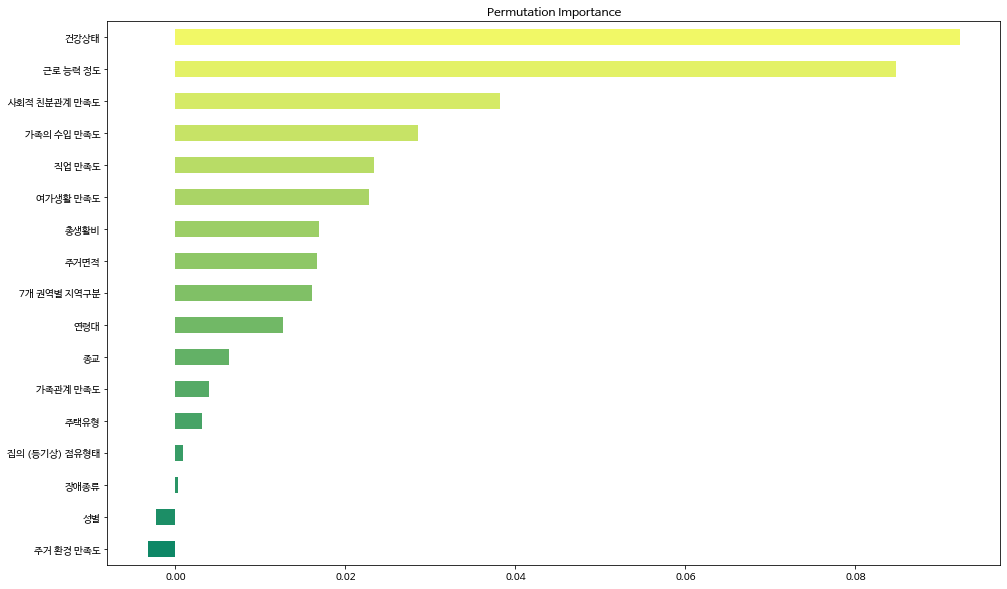

In [73]:
feature_names = X_test.columns.tolist()
pi = pd.Series(permuter.feature_importances_, feature_names).sort_values()
plt.figure(figsize=(16,10))
colors = sns.color_palette('summer', len(feature_names))
pi.plot.barh(color=colors)
plt.title("Permutation Importance")
plt.show()

In [56]:
eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
0.0878 ± 0.0320,건강상태
0.0826 ± 0.0245,근로 능력 정도
0.0403 ± 0.0116,사회적 친분관계 만족도
0.0322 ± 0.0111,여가생활 만족도
0.0293 ± 0.0171,총생활비
0.0242 ± 0.0104,가족의 수입 만족도
0.0230 ± 0.0128,직업 만족도
0.0123 ± 0.0134,가족관계 만족도
0.0121 ± 0.0102,7개 권역별 지역구분
0.0107 ± 0.0084,주거면적
